In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report

from sklearn.utils.class_weight import compute_class_weight

<h1>Data import</h1>

In [2]:
ctl = pd.read_csv('Data/smad_timecourse_singlecells_ctl.csv')
times = ctl['time']
ctl = ctl.drop(columns='time')

In [3]:
tgfb_low = pd.read_csv('Data/smad_timecourse_singlecells_tgfb_low.csv').drop(columns='time')
print(f"tgfb size: {tgfb_low.values.T.shape}")
gdf11_high = pd.read_csv('Data/smad_timecourse_singlecells_gdf11_high.csv').drop(columns='time')
print(f"gdf11 size: {gdf11_high.values.T.shape}")

tgfb size: (1230, 288)
gdf11 size: (2692, 288)


In [4]:
x_total = np.concatenate([ctl.values.T,tgfb_low.values.T,gdf11_high.values.T],axis=0).reshape([-1,ctl.shape[0],1])
y_total = np.concatenate([np.ones(ctl.shape[1]),2*np.ones(tgfb_low.shape[1]),3*np.ones(gdf11_high.shape[1])])

In [5]:
x_train,x_test,y_train,y_test = train_test_split(x_total,y_total,test_size=0.25)
print('x_train,y_train:',x_train.shape,y_train.shape)

x_train,y_train: (6300, 288, 1) (6300,)


In [6]:
one_hot_encoder = OneHotEncoder(sparse=False)
one_hot_encoder.fit(y_train.reshape([-1,1]))
y_train_oh,y_test_oh = one_hot_encoder.transform(y_train.reshape([-1,1])),one_hot_encoder.transform(y_test.reshape([-1,1]))

print('y_train_oh:',y_train_oh.shape)

y_train_oh: (6300, 3)


<h1>Deeplearning</h1>

In [7]:
import tensorflow as tf
import tensorflow.keras as kr

In [140]:
def plotFitting(optim):
    plt.figure(figsize=(8,4))
    plt.subplot(1,2,1)
    plt.plot(optim.history['loss'])
    plt.plot(optim.history['val_loss'])
    plt.ylabel('loss (Categorial crossentropy)')
    plt.xlabel('epochs')
    plt.ylim(0)

    plt.subplot(1,2,2)
    plt.plot(optim.history['categorical_accuracy'])
    plt.plot(optim.history['val_categorical_accuracy'])
    plt.ylabel('Accuracy (Categorial)')
    plt.xlabel('epochs')
    plt.ylim(0)

    plt.tight_layout()

In [141]:
def evaluatePerformance(model):
    with tf.device('/GPU:0'): 
        _,acc = model.evaluate(x_test,y_test_oh)
        y_pred = model.predict(x_test)
    cat_acc = np.mean(np.argmax(y_pred,axis=1)+1 == y_test)
    print('correct classified: %.1f %%'%(cat_acc*100))

    conf_mat = confusion_matrix(y_test,np.argmax(y_pred,axis=1)+1)
    conf_mat_disp = ConfusionMatrixDisplay(conf_mat)
    conf_mat_disp.plot()
    print(classification_report(y_test,np.argmax(y_pred,axis=1)+1))

<h3>Encoder module</h3>

In [192]:
def EncoderModule(inp,n_kernels = 16,kernel_width = 12,strides = 3):
    dense1 = kr.layers.Dense(n_kernels, activation="relu")(inp)
    drop1 = kr.layers.Dropout(0.2)(dense1)
    conv1 = kr.layers.Conv1D(n_kernels, kernel_width, activation="relu", strides=strides)(drop1)
    maxpool = kr.layers.MaxPool1D()(conv1)
    dense2 = kr.layers.Dense(n_kernels, activation="relu")(maxpool)
    drop2 = kr.layers.Dropout(0.2)(dense2)
    conv2 = kr.layers.Conv1D(n_kernels, kernel_width, activation="relu", strides=strides)(drop2)
        
    conv_module = kr.Model(inputs=inp,outputs=conv2)
    return conv_module

inp = kr.Input((288,1))
conv_module = EncoderModule(inp)
conv_module.summary()

Model: "functional_132"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_69 (InputLayer)        [(None, 288, 1)]          0         
_________________________________________________________________
dense_137 (Dense)            (None, 288, 16)           32        
_________________________________________________________________
dropout_41 (Dropout)         (None, 288, 16)           0         
_________________________________________________________________
conv1d_54 (Conv1D)           (None, 93, 16)            3088      
_________________________________________________________________
max_pooling1d_27 (MaxPooling (None, 46, 16)            0         
_________________________________________________________________
dense_138 (Dense)            (None, 46, 16)            272       
_________________________________________________________________
dropout_42 (Dropout)         (None, 46, 16)         

### Baseline model

In [218]:
inp = kr.Input((288,1))

encoder_key = EncoderModule(inp)
encoder_value = EncoderModule(inp)
attention_encoded = kr.layers.Concatenate()([encoder_key(inp),encoder_value(inp)])

hidden1 = kr.layers.Dense(16,activation='relu')(attention_encoded)
hidden2 = kr.layers.Dense(8,activation='relu')(hidden1)
hidden3 = kr.layers.Dense(4,activation='relu')(hidden2)
flat = kr.layers.Flatten()(hidden3)
out = kr.layers.Dense(3,activation='sigmoid')(flat)

baseline_model = kr.Model(inputs=inp,outputs=out)
optimizer = kr.optimizers.Adam(learning_rate=0.0003)
baseline_model.compile(
    optimizer=optimizer,
    loss=kr.losses.categorical_crossentropy,
    metrics=[kr.metrics.categorical_accuracy]
)
baseline_model.summary()

Model: "functional_186"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_81 (InputLayer)           [(None, 288, 1)]     0                                            
__________________________________________________________________________________________________
functional_182 (Functional)     (None, 12, 16)       6480        input_81[0][0]                   
__________________________________________________________________________________________________
functional_184 (Functional)     (None, 12, 16)       6480        input_81[0][0]                   
__________________________________________________________________________________________________
concatenate_19 (Concatenate)    (None, 12, 32)       0           functional_182[0][0]             
                                                                 functional_184[0][0]

In [219]:
with tf.device('/GPU:0'):
    baseline_optim = baseline_model.fit(x=x_train,y=y_train_oh,batch_size=256,epochs=600,
                  validation_split=0.25,shuffle=False)

Epoch 1/600
19/19 [==============================] - 1s 44ms/step - loss: 1.0979 - categorical_accuracy: 0.3757 - val_loss: 1.0970 - val_categorical_accuracy: 0.4057
Epoch 2/600
19/19 [==============================] - 1s 35ms/step - loss: 1.0954 - categorical_accuracy: 0.3958 - val_loss: 1.0933 - val_categorical_accuracy: 0.3168
Epoch 3/600
19/19 [==============================] - 1s 33ms/step - loss: 1.0881 - categorical_accuracy: 0.3395 - val_loss: 1.0808 - val_categorical_accuracy: 0.3200
Epoch 4/600
19/19 [==============================] - 1s 34ms/step - loss: 1.0606 - categorical_accuracy: 0.3346 - val_loss: 1.0468 - val_categorical_accuracy: 0.3378
Epoch 5/600
19/19 [==============================] - 1s 34ms/step - loss: 1.0233 - categorical_accuracy: 0.4146 - val_loss: 1.0099 - val_categorical_accuracy: 0.5073
Epoch 6/600
19/19 [==============================] - 1s 34ms/step - loss: 0.9835 - categorical_accuracy: 0.5200 - val_loss: 0.9640 - val_categorical_accuracy: 0.5213
Epoc

19/19 [==============================] - 1s 37ms/step - loss: 0.7113 - categorical_accuracy: 0.6626 - val_loss: 0.7094 - val_categorical_accuracy: 0.6463
Epoch 51/600
19/19 [==============================] - 1s 37ms/step - loss: 0.7048 - categorical_accuracy: 0.6639 - val_loss: 0.7046 - val_categorical_accuracy: 0.6521
Epoch 52/600
19/19 [==============================] - 1s 38ms/step - loss: 0.7005 - categorical_accuracy: 0.6620 - val_loss: 0.7026 - val_categorical_accuracy: 0.6533
Epoch 53/600
19/19 [==============================] - 1s 38ms/step - loss: 0.7017 - categorical_accuracy: 0.6646 - val_loss: 0.6979 - val_categorical_accuracy: 0.6552
Epoch 54/600
19/19 [==============================] - 1s 36ms/step - loss: 0.6921 - categorical_accuracy: 0.6635 - val_loss: 0.6983 - val_categorical_accuracy: 0.6610
Epoch 55/600
19/19 [==============================] - 1s 38ms/step - loss: 0.6943 - categorical_accuracy: 0.6692 - val_loss: 0.6955 - val_categorical_accuracy: 0.6597
Epoch 56/60

19/19 [==============================] - 1s 38ms/step - loss: 0.6233 - categorical_accuracy: 0.7020 - val_loss: 0.6319 - val_categorical_accuracy: 0.6902
Epoch 100/600
19/19 [==============================] - 1s 37ms/step - loss: 0.6237 - categorical_accuracy: 0.7005 - val_loss: 0.6306 - val_categorical_accuracy: 0.6914
Epoch 101/600
19/19 [==============================] - 1s 38ms/step - loss: 0.6199 - categorical_accuracy: 0.7046 - val_loss: 0.6297 - val_categorical_accuracy: 0.6895
Epoch 102/600
19/19 [==============================] - 1s 36ms/step - loss: 0.6146 - categorical_accuracy: 0.7149 - val_loss: 0.6298 - val_categorical_accuracy: 0.6895
Epoch 103/600
19/19 [==============================] - 1s 38ms/step - loss: 0.6249 - categorical_accuracy: 0.7046 - val_loss: 0.6286 - val_categorical_accuracy: 0.6921
Epoch 104/600
19/19 [==============================] - 1s 37ms/step - loss: 0.6228 - categorical_accuracy: 0.7071 - val_loss: 0.6252 - val_categorical_accuracy: 0.6914
Epoch 

Epoch 148/600
19/19 [==============================] - 1s 36ms/step - loss: 0.5758 - categorical_accuracy: 0.7297 - val_loss: 0.5892 - val_categorical_accuracy: 0.7162
Epoch 149/600
19/19 [==============================] - 1s 39ms/step - loss: 0.5685 - categorical_accuracy: 0.7363 - val_loss: 0.5833 - val_categorical_accuracy: 0.7124
Epoch 150/600
19/19 [==============================] - 1s 38ms/step - loss: 0.5737 - categorical_accuracy: 0.7331 - val_loss: 0.5823 - val_categorical_accuracy: 0.7143
Epoch 151/600
19/19 [==============================] - 1s 36ms/step - loss: 0.5739 - categorical_accuracy: 0.7316 - val_loss: 0.5811 - val_categorical_accuracy: 0.7149
Epoch 152/600
19/19 [==============================] - 1s 38ms/step - loss: 0.5713 - categorical_accuracy: 0.7367 - val_loss: 0.5858 - val_categorical_accuracy: 0.7181
Epoch 153/600
19/19 [==============================] - 1s 37ms/step - loss: 0.5636 - categorical_accuracy: 0.7401 - val_loss: 0.5828 - val_categorical_accuracy:

19/19 [==============================] - 1s 37ms/step - loss: 0.5406 - categorical_accuracy: 0.7501 - val_loss: 0.5519 - val_categorical_accuracy: 0.7327
Epoch 197/600
19/19 [==============================] - 1s 38ms/step - loss: 0.5355 - categorical_accuracy: 0.7522 - val_loss: 0.5531 - val_categorical_accuracy: 0.7283
Epoch 198/600
19/19 [==============================] - 1s 38ms/step - loss: 0.5366 - categorical_accuracy: 0.7486 - val_loss: 0.5545 - val_categorical_accuracy: 0.7270
Epoch 199/600
19/19 [==============================] - 1s 38ms/step - loss: 0.5380 - categorical_accuracy: 0.7524 - val_loss: 0.5475 - val_categorical_accuracy: 0.7321
Epoch 200/600
19/19 [==============================] - 1s 38ms/step - loss: 0.5369 - categorical_accuracy: 0.7551 - val_loss: 0.5529 - val_categorical_accuracy: 0.7295
Epoch 201/600
19/19 [==============================] - 1s 38ms/step - loss: 0.5401 - categorical_accuracy: 0.7513 - val_loss: 0.5489 - val_categorical_accuracy: 0.7327
Epoch 

Epoch 245/600
19/19 [==============================] - 1s 37ms/step - loss: 0.5137 - categorical_accuracy: 0.7611 - val_loss: 0.5245 - val_categorical_accuracy: 0.7467
Epoch 246/600
19/19 [==============================] - 1s 38ms/step - loss: 0.5031 - categorical_accuracy: 0.7685 - val_loss: 0.5237 - val_categorical_accuracy: 0.7448
Epoch 247/600
19/19 [==============================] - 1s 38ms/step - loss: 0.5062 - categorical_accuracy: 0.7647 - val_loss: 0.5230 - val_categorical_accuracy: 0.7492
Epoch 248/600
19/19 [==============================] - 1s 37ms/step - loss: 0.5050 - categorical_accuracy: 0.7685 - val_loss: 0.5244 - val_categorical_accuracy: 0.7492
Epoch 249/600
19/19 [==============================] - 1s 38ms/step - loss: 0.5057 - categorical_accuracy: 0.7666 - val_loss: 0.5224 - val_categorical_accuracy: 0.7517
Epoch 250/600
19/19 [==============================] - 1s 37ms/step - loss: 0.5026 - categorical_accuracy: 0.7657 - val_loss: 0.5189 - val_categorical_accuracy:

Epoch 294/600
19/19 [==============================] - 1s 38ms/step - loss: 0.4783 - categorical_accuracy: 0.7892 - val_loss: 0.4961 - val_categorical_accuracy: 0.7625
Epoch 295/600
19/19 [==============================] - 1s 37ms/step - loss: 0.4765 - categorical_accuracy: 0.7793 - val_loss: 0.4943 - val_categorical_accuracy: 0.7651
Epoch 296/600
19/19 [==============================] - 1s 37ms/step - loss: 0.4739 - categorical_accuracy: 0.7856 - val_loss: 0.4952 - val_categorical_accuracy: 0.7632
Epoch 297/600
19/19 [==============================] - 1s 37ms/step - loss: 0.4736 - categorical_accuracy: 0.7852 - val_loss: 0.4945 - val_categorical_accuracy: 0.7663
Epoch 298/600
19/19 [==============================] - 1s 36ms/step - loss: 0.4759 - categorical_accuracy: 0.7782 - val_loss: 0.4954 - val_categorical_accuracy: 0.7606
Epoch 299/600
19/19 [==============================] - 1s 37ms/step - loss: 0.4731 - categorical_accuracy: 0.7841 - val_loss: 0.4934 - val_categorical_accuracy:

Epoch 343/600
19/19 [==============================] - 1s 38ms/step - loss: 0.4498 - categorical_accuracy: 0.8006 - val_loss: 0.4706 - val_categorical_accuracy: 0.7829
Epoch 344/600
19/19 [==============================] - 1s 36ms/step - loss: 0.4506 - categorical_accuracy: 0.7992 - val_loss: 0.4685 - val_categorical_accuracy: 0.7822
Epoch 345/600
19/19 [==============================] - 1s 36ms/step - loss: 0.4510 - categorical_accuracy: 0.7968 - val_loss: 0.4685 - val_categorical_accuracy: 0.7790
Epoch 346/600
19/19 [==============================] - 1s 38ms/step - loss: 0.4515 - categorical_accuracy: 0.7964 - val_loss: 0.4684 - val_categorical_accuracy: 0.7810
Epoch 347/600
19/19 [==============================] - 1s 36ms/step - loss: 0.4555 - categorical_accuracy: 0.7917 - val_loss: 0.4669 - val_categorical_accuracy: 0.7841
Epoch 348/600
19/19 [==============================] - 1s 37ms/step - loss: 0.4442 - categorical_accuracy: 0.8053 - val_loss: 0.4640 - val_categorical_accuracy:

Epoch 392/600
19/19 [==============================] - 1s 37ms/step - loss: 0.4223 - categorical_accuracy: 0.8129 - val_loss: 0.4439 - val_categorical_accuracy: 0.7987
Epoch 393/600
19/19 [==============================] - 1s 39ms/step - loss: 0.4237 - categorical_accuracy: 0.8116 - val_loss: 0.4398 - val_categorical_accuracy: 0.8051
Epoch 394/600
19/19 [==============================] - 1s 38ms/step - loss: 0.4238 - categorical_accuracy: 0.8154 - val_loss: 0.4432 - val_categorical_accuracy: 0.8019
Epoch 395/600
19/19 [==============================] - 1s 36ms/step - loss: 0.4204 - categorical_accuracy: 0.8148 - val_loss: 0.4397 - val_categorical_accuracy: 0.8013
Epoch 396/600
19/19 [==============================] - 1s 37ms/step - loss: 0.4191 - categorical_accuracy: 0.8159 - val_loss: 0.4371 - val_categorical_accuracy: 0.8038
Epoch 397/600
19/19 [==============================] - 1s 37ms/step - loss: 0.4205 - categorical_accuracy: 0.8186 - val_loss: 0.4396 - val_categorical_accuracy:

Epoch 441/600
19/19 [==============================] - 1s 37ms/step - loss: 0.3879 - categorical_accuracy: 0.8349 - val_loss: 0.4128 - val_categorical_accuracy: 0.8235
Epoch 442/600
19/19 [==============================] - 1s 37ms/step - loss: 0.3937 - categorical_accuracy: 0.8241 - val_loss: 0.4161 - val_categorical_accuracy: 0.8165
Epoch 443/600
19/19 [==============================] - 1s 38ms/step - loss: 0.4022 - categorical_accuracy: 0.8224 - val_loss: 0.4118 - val_categorical_accuracy: 0.8197
Epoch 444/600
19/19 [==============================] - 1s 36ms/step - loss: 0.4015 - categorical_accuracy: 0.8275 - val_loss: 0.4145 - val_categorical_accuracy: 0.8197
Epoch 445/600
19/19 [==============================] - 1s 39ms/step - loss: 0.3985 - categorical_accuracy: 0.8326 - val_loss: 0.4101 - val_categorical_accuracy: 0.8229
Epoch 446/600
19/19 [==============================] - 1s 37ms/step - loss: 0.3963 - categorical_accuracy: 0.8275 - val_loss: 0.4175 - val_categorical_accuracy:

Epoch 490/600
19/19 [==============================] - 1s 36ms/step - loss: 0.3699 - categorical_accuracy: 0.8413 - val_loss: 0.3950 - val_categorical_accuracy: 0.8273
Epoch 491/600
19/19 [==============================] - 1s 37ms/step - loss: 0.3848 - categorical_accuracy: 0.8370 - val_loss: 0.3938 - val_categorical_accuracy: 0.8305
Epoch 492/600
19/19 [==============================] - 1s 37ms/step - loss: 0.3693 - categorical_accuracy: 0.8444 - val_loss: 0.3920 - val_categorical_accuracy: 0.8305
Epoch 493/600
19/19 [==============================] - 1s 36ms/step - loss: 0.3725 - categorical_accuracy: 0.8423 - val_loss: 0.3973 - val_categorical_accuracy: 0.8292
Epoch 494/600
19/19 [==============================] - 1s 37ms/step - loss: 0.3722 - categorical_accuracy: 0.8419 - val_loss: 0.3949 - val_categorical_accuracy: 0.8317
Epoch 495/600
19/19 [==============================] - 1s 36ms/step - loss: 0.3594 - categorical_accuracy: 0.8453 - val_loss: 0.3926 - val_categorical_accuracy:

19/19 [==============================] - 1s 39ms/step - loss: 0.3492 - categorical_accuracy: 0.8565 - val_loss: 0.3728 - val_categorical_accuracy: 0.8457
Epoch 539/600
19/19 [==============================] - 1s 37ms/step - loss: 0.3438 - categorical_accuracy: 0.8576 - val_loss: 0.3716 - val_categorical_accuracy: 0.8483
Epoch 540/600
19/19 [==============================] - 1s 37ms/step - loss: 0.3439 - categorical_accuracy: 0.8542 - val_loss: 0.3701 - val_categorical_accuracy: 0.8470
Epoch 541/600
19/19 [==============================] - 1s 38ms/step - loss: 0.3432 - categorical_accuracy: 0.8561 - val_loss: 0.3711 - val_categorical_accuracy: 0.8470
Epoch 542/600
19/19 [==============================] - 1s 36ms/step - loss: 0.3480 - categorical_accuracy: 0.8569 - val_loss: 0.3708 - val_categorical_accuracy: 0.8489
Epoch 543/600
19/19 [==============================] - 1s 38ms/step - loss: 0.3337 - categorical_accuracy: 0.8639 - val_loss: 0.3706 - val_categorical_accuracy: 0.8489
Epoch 

Epoch 587/600
19/19 [==============================] - 1s 38ms/step - loss: 0.3266 - categorical_accuracy: 0.8673 - val_loss: 0.3546 - val_categorical_accuracy: 0.8578
Epoch 588/600
19/19 [==============================] - 1s 36ms/step - loss: 0.3280 - categorical_accuracy: 0.8696 - val_loss: 0.3520 - val_categorical_accuracy: 0.8635
Epoch 589/600
19/19 [==============================] - 1s 38ms/step - loss: 0.3227 - categorical_accuracy: 0.8686 - val_loss: 0.3502 - val_categorical_accuracy: 0.8641
Epoch 590/600
19/19 [==============================] - 1s 37ms/step - loss: 0.3202 - categorical_accuracy: 0.8654 - val_loss: 0.3518 - val_categorical_accuracy: 0.8654
Epoch 591/600
19/19 [==============================] - 1s 36ms/step - loss: 0.3216 - categorical_accuracy: 0.8688 - val_loss: 0.3522 - val_categorical_accuracy: 0.8660
Epoch 592/600
19/19 [==============================] - 1s 37ms/step - loss: 0.3245 - categorical_accuracy: 0.8720 - val_loss: 0.3488 - val_categorical_accuracy:

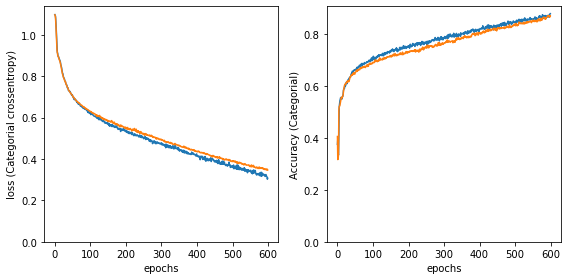

In [220]:
plotFitting(baseline_optim)

66/66 [==============================] - 0s 2ms/step - loss: 0.3553 - categorical_accuracy: 0.8714
correct classified: 87.1 %
              precision    recall  f1-score   support

         1.0       0.85      0.93      0.89      1112
         2.0       0.97      0.91      0.94       307
         3.0       0.86      0.77      0.81       681

    accuracy                           0.87      2100
   macro avg       0.89      0.87      0.88      2100
weighted avg       0.87      0.87      0.87      2100



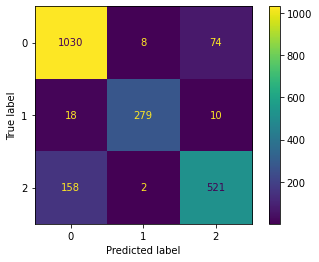

In [221]:
evaluatePerformance(baseline_model)

### Attention model

In [205]:
inp = kr.Input((288,1))
encoder_key = EncoderModule(inp)
encoder_value = EncoderModule(inp)

attention = kr.layers.Attention()([encoder_key(inp),encoder_value(inp)])
attention_encoded = kr.layers.Concatenate()([encoder_key(inp),attention])

hidden1 = kr.layers.Dense(16,activation='relu')(attention_encoded)
hidden2 = kr.layers.Dense(8,activation='relu')(hidden1)
hidden3 = kr.layers.Dense(4,activation='relu')(hidden2)
flat = kr.layers.Flatten()(hidden3)
out = kr.layers.Dense(3,activation='sigmoid')(flat)

attention_model = kr.Model(inputs=inp,outputs=out)
optimizer = kr.optimizers.Adam(learning_rate=0.0003)
attention_model.compile(
    optimizer=optimizer,
    loss=kr.losses.categorical_crossentropy,
    metrics=[kr.metrics.categorical_accuracy]
)
attention_model.summary()

Model: "functional_174"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_80 (InputLayer)           [(None, 288, 1)]     0                                            
__________________________________________________________________________________________________
functional_170 (Functional)     (None, 12, 16)       6480        input_80[0][0]                   
                                                                 input_80[0][0]                   
__________________________________________________________________________________________________
functional_172 (Functional)     (None, 12, 16)       6480        input_80[0][0]                   
__________________________________________________________________________________________________
attention_27 (Attention)        (None, 12, 16)       0           functional_170[0][0]

In [206]:
with tf.device('/GPU:0'):
    attention_optim = attention_model.fit(x=x_train,y=y_train_oh,batch_size=256,epochs=600,
                  validation_split=0.25,shuffle=False)

Epoch 1/600
19/19 [==============================] - 1s 61ms/step - loss: 1.0975 - categorical_accuracy: 0.3564 - val_loss: 1.0950 - val_categorical_accuracy: 0.3213
Epoch 2/600
19/19 [==============================] - 1s 49ms/step - loss: 1.0915 - categorical_accuracy: 0.3187 - val_loss: 1.0875 - val_categorical_accuracy: 0.3213
Epoch 3/600
19/19 [==============================] - 1s 48ms/step - loss: 1.0763 - categorical_accuracy: 0.3185 - val_loss: 1.0687 - val_categorical_accuracy: 0.3213
Epoch 4/600
19/19 [==============================] - 1s 48ms/step - loss: 1.0508 - categorical_accuracy: 0.3200 - val_loss: 1.0444 - val_categorical_accuracy: 0.3295
Epoch 5/600
19/19 [==============================] - 1s 46ms/step - loss: 1.0211 - categorical_accuracy: 0.4432 - val_loss: 1.0184 - val_categorical_accuracy: 0.5232
Epoch 6/600
19/19 [==============================] - 1s 48ms/step - loss: 0.9947 - categorical_accuracy: 0.5378 - val_loss: 0.9976 - val_categorical_accuracy: 0.5232
Epoc

Epoch 50/600
19/19 [==============================] - 1s 52ms/step - loss: 0.6926 - categorical_accuracy: 0.6713 - val_loss: 0.7147 - val_categorical_accuracy: 0.6400
Epoch 51/600
19/19 [==============================] - 1s 54ms/step - loss: 0.6931 - categorical_accuracy: 0.6639 - val_loss: 0.7094 - val_categorical_accuracy: 0.6406
Epoch 52/600
19/19 [==============================] - 1s 52ms/step - loss: 0.6813 - categorical_accuracy: 0.6760 - val_loss: 0.7093 - val_categorical_accuracy: 0.6425
Epoch 53/600
19/19 [==============================] - 1s 54ms/step - loss: 0.6884 - categorical_accuracy: 0.6751 - val_loss: 0.7101 - val_categorical_accuracy: 0.6419
Epoch 54/600
19/19 [==============================] - 1s 52ms/step - loss: 0.6795 - categorical_accuracy: 0.6743 - val_loss: 0.7039 - val_categorical_accuracy: 0.6444
Epoch 55/600
19/19 [==============================] - 1s 53ms/step - loss: 0.6816 - categorical_accuracy: 0.6749 - val_loss: 0.7025 - val_categorical_accuracy: 0.650

19/19 [==============================] - 1s 53ms/step - loss: 0.5673 - categorical_accuracy: 0.7450 - val_loss: 0.5925 - val_categorical_accuracy: 0.7213
Epoch 100/600
19/19 [==============================] - 1s 54ms/step - loss: 0.5613 - categorical_accuracy: 0.7462 - val_loss: 0.5890 - val_categorical_accuracy: 0.7257
Epoch 101/600
19/19 [==============================] - 1s 53ms/step - loss: 0.5634 - categorical_accuracy: 0.7462 - val_loss: 0.5838 - val_categorical_accuracy: 0.7340
Epoch 102/600
19/19 [==============================] - 1s 54ms/step - loss: 0.5654 - categorical_accuracy: 0.7479 - val_loss: 0.5951 - val_categorical_accuracy: 0.7244
Epoch 103/600
19/19 [==============================] - 1s 53ms/step - loss: 0.5570 - categorical_accuracy: 0.7475 - val_loss: 0.5939 - val_categorical_accuracy: 0.7251
Epoch 104/600
19/19 [==============================] - 1s 53ms/step - loss: 0.5600 - categorical_accuracy: 0.7501 - val_loss: 0.5850 - val_categorical_accuracy: 0.7263
Epoch 

Epoch 148/600
19/19 [==============================] - 1s 53ms/step - loss: 0.4754 - categorical_accuracy: 0.8021 - val_loss: 0.5076 - val_categorical_accuracy: 0.7778
Epoch 149/600
19/19 [==============================] - 1s 53ms/step - loss: 0.4744 - categorical_accuracy: 0.7924 - val_loss: 0.5033 - val_categorical_accuracy: 0.7784
Epoch 150/600
19/19 [==============================] - 1s 53ms/step - loss: 0.4767 - categorical_accuracy: 0.7966 - val_loss: 0.5019 - val_categorical_accuracy: 0.7790
Epoch 151/600
19/19 [==============================] - 1s 53ms/step - loss: 0.4676 - categorical_accuracy: 0.7941 - val_loss: 0.5028 - val_categorical_accuracy: 0.7759
Epoch 152/600
19/19 [==============================] - 1s 54ms/step - loss: 0.4764 - categorical_accuracy: 0.7898 - val_loss: 0.5085 - val_categorical_accuracy: 0.7790
Epoch 153/600
19/19 [==============================] - 1s 54ms/step - loss: 0.4757 - categorical_accuracy: 0.7947 - val_loss: 0.5005 - val_categorical_accuracy:

Epoch 197/600
19/19 [==============================] - 1s 53ms/step - loss: 0.4156 - categorical_accuracy: 0.8229 - val_loss: 0.4558 - val_categorical_accuracy: 0.8102
Epoch 198/600
19/19 [==============================] - 1s 53ms/step - loss: 0.4238 - categorical_accuracy: 0.8231 - val_loss: 0.4540 - val_categorical_accuracy: 0.8146
Epoch 199/600
19/19 [==============================] - 1s 53ms/step - loss: 0.4163 - categorical_accuracy: 0.8239 - val_loss: 0.4486 - val_categorical_accuracy: 0.8146
Epoch 200/600
19/19 [==============================] - 1s 53ms/step - loss: 0.4097 - categorical_accuracy: 0.8339 - val_loss: 0.4445 - val_categorical_accuracy: 0.8152
Epoch 201/600
19/19 [==============================] - 1s 52ms/step - loss: 0.4128 - categorical_accuracy: 0.8277 - val_loss: 0.4493 - val_categorical_accuracy: 0.8152
Epoch 202/600
19/19 [==============================] - 1s 54ms/step - loss: 0.4116 - categorical_accuracy: 0.8275 - val_loss: 0.4417 - val_categorical_accuracy:

Epoch 246/600
19/19 [==============================] - 1s 57ms/step - loss: 0.3812 - categorical_accuracy: 0.8432 - val_loss: 0.4105 - val_categorical_accuracy: 0.8362
Epoch 247/600
19/19 [==============================] - 1s 53ms/step - loss: 0.3683 - categorical_accuracy: 0.8533 - val_loss: 0.4143 - val_categorical_accuracy: 0.8381
Epoch 248/600
19/19 [==============================] - 1s 53ms/step - loss: 0.3706 - categorical_accuracy: 0.8425 - val_loss: 0.4032 - val_categorical_accuracy: 0.8444
Epoch 249/600
19/19 [==============================] - 1s 51ms/step - loss: 0.3656 - categorical_accuracy: 0.8550 - val_loss: 0.4012 - val_categorical_accuracy: 0.8413
Epoch 250/600
19/19 [==============================] - 1s 52ms/step - loss: 0.3631 - categorical_accuracy: 0.8514 - val_loss: 0.3977 - val_categorical_accuracy: 0.8400
Epoch 251/600
19/19 [==============================] - 1s 52ms/step - loss: 0.3627 - categorical_accuracy: 0.8480 - val_loss: 0.3995 - val_categorical_accuracy:

Epoch 295/600
19/19 [==============================] - 1s 54ms/step - loss: 0.3347 - categorical_accuracy: 0.8597 - val_loss: 0.3729 - val_categorical_accuracy: 0.8559
Epoch 296/600
19/19 [==============================] - 1s 53ms/step - loss: 0.3219 - categorical_accuracy: 0.8688 - val_loss: 0.3697 - val_categorical_accuracy: 0.8597
Epoch 297/600
19/19 [==============================] - 1s 53ms/step - loss: 0.3167 - categorical_accuracy: 0.8709 - val_loss: 0.3670 - val_categorical_accuracy: 0.8584
Epoch 298/600
19/19 [==============================] - 1s 51ms/step - loss: 0.3303 - categorical_accuracy: 0.8667 - val_loss: 0.3686 - val_categorical_accuracy: 0.8565
Epoch 299/600
19/19 [==============================] - 1s 54ms/step - loss: 0.3157 - categorical_accuracy: 0.8734 - val_loss: 0.3681 - val_categorical_accuracy: 0.8584
Epoch 300/600
19/19 [==============================] - 1s 51ms/step - loss: 0.3217 - categorical_accuracy: 0.8698 - val_loss: 0.3617 - val_categorical_accuracy:

Epoch 344/600
19/19 [==============================] - 1s 52ms/step - loss: 0.2902 - categorical_accuracy: 0.8842 - val_loss: 0.3382 - val_categorical_accuracy: 0.8756
Epoch 345/600
19/19 [==============================] - 1s 53ms/step - loss: 0.2824 - categorical_accuracy: 0.8872 - val_loss: 0.3359 - val_categorical_accuracy: 0.8737
Epoch 346/600
19/19 [==============================] - 1s 53ms/step - loss: 0.2933 - categorical_accuracy: 0.8834 - val_loss: 0.3353 - val_categorical_accuracy: 0.8679
Epoch 347/600
19/19 [==============================] - 1s 54ms/step - loss: 0.2974 - categorical_accuracy: 0.8794 - val_loss: 0.3343 - val_categorical_accuracy: 0.8711
Epoch 348/600
19/19 [==============================] - 1s 53ms/step - loss: 0.2890 - categorical_accuracy: 0.8832 - val_loss: 0.3333 - val_categorical_accuracy: 0.8749
Epoch 349/600
19/19 [==============================] - 1s 54ms/step - loss: 0.2896 - categorical_accuracy: 0.8889 - val_loss: 0.3306 - val_categorical_accuracy:

Epoch 393/600
19/19 [==============================] - 1s 51ms/step - loss: 0.2599 - categorical_accuracy: 0.8912 - val_loss: 0.3136 - val_categorical_accuracy: 0.8832
Epoch 394/600
19/19 [==============================] - 1s 53ms/step - loss: 0.2600 - categorical_accuracy: 0.8959 - val_loss: 0.3111 - val_categorical_accuracy: 0.8863
Epoch 395/600
19/19 [==============================] - 1s 51ms/step - loss: 0.2591 - categorical_accuracy: 0.8948 - val_loss: 0.3146 - val_categorical_accuracy: 0.8844
Epoch 396/600
19/19 [==============================] - 1s 52ms/step - loss: 0.2693 - categorical_accuracy: 0.8904 - val_loss: 0.3125 - val_categorical_accuracy: 0.8876
Epoch 397/600
19/19 [==============================] - 1s 52ms/step - loss: 0.2648 - categorical_accuracy: 0.8931 - val_loss: 0.3102 - val_categorical_accuracy: 0.8863
Epoch 398/600
19/19 [==============================] - 1s 53ms/step - loss: 0.2682 - categorical_accuracy: 0.8931 - val_loss: 0.3138 - val_categorical_accuracy:

Epoch 442/600
19/19 [==============================] - 1s 53ms/step - loss: 0.2533 - categorical_accuracy: 0.8976 - val_loss: 0.2910 - val_categorical_accuracy: 0.8959
Epoch 443/600
19/19 [==============================] - 1s 51ms/step - loss: 0.2502 - categorical_accuracy: 0.9031 - val_loss: 0.2909 - val_categorical_accuracy: 0.8978
Epoch 444/600
19/19 [==============================] - 1s 53ms/step - loss: 0.2459 - categorical_accuracy: 0.9001 - val_loss: 0.2972 - val_categorical_accuracy: 0.8952
Epoch 445/600
19/19 [==============================] - 1s 51ms/step - loss: 0.2391 - categorical_accuracy: 0.9096 - val_loss: 0.2966 - val_categorical_accuracy: 0.8902
Epoch 446/600
19/19 [==============================] - 1s 53ms/step - loss: 0.2402 - categorical_accuracy: 0.9043 - val_loss: 0.2884 - val_categorical_accuracy: 0.8965
Epoch 447/600
19/19 [==============================] - 1s 51ms/step - loss: 0.2353 - categorical_accuracy: 0.9050 - val_loss: 0.2905 - val_categorical_accuracy:

Epoch 491/600
19/19 [==============================] - 1s 53ms/step - loss: 0.2146 - categorical_accuracy: 0.9145 - val_loss: 0.2795 - val_categorical_accuracy: 0.9003
Epoch 492/600
19/19 [==============================] - 1s 52ms/step - loss: 0.2245 - categorical_accuracy: 0.9081 - val_loss: 0.2864 - val_categorical_accuracy: 0.9010
Epoch 493/600
19/19 [==============================] - 1s 54ms/step - loss: 0.2301 - categorical_accuracy: 0.9111 - val_loss: 0.2783 - val_categorical_accuracy: 0.9022
Epoch 494/600
19/19 [==============================] - 1s 53ms/step - loss: 0.2364 - categorical_accuracy: 0.9065 - val_loss: 0.2814 - val_categorical_accuracy: 0.9041
Epoch 495/600
19/19 [==============================] - 1s 54ms/step - loss: 0.2235 - categorical_accuracy: 0.9130 - val_loss: 0.2825 - val_categorical_accuracy: 0.9016
Epoch 496/600
19/19 [==============================] - 1s 52ms/step - loss: 0.2192 - categorical_accuracy: 0.9115 - val_loss: 0.2779 - val_categorical_accuracy:

Epoch 540/600
19/19 [==============================] - 1s 53ms/step - loss: 0.2086 - categorical_accuracy: 0.9194 - val_loss: 0.2711 - val_categorical_accuracy: 0.9086
Epoch 541/600
19/19 [==============================] - 1s 53ms/step - loss: 0.1991 - categorical_accuracy: 0.9249 - val_loss: 0.2684 - val_categorical_accuracy: 0.9060
Epoch 542/600
19/19 [==============================] - 1s 52ms/step - loss: 0.2061 - categorical_accuracy: 0.9160 - val_loss: 0.2763 - val_categorical_accuracy: 0.9041
Epoch 543/600
19/19 [==============================] - 1s 53ms/step - loss: 0.2056 - categorical_accuracy: 0.9200 - val_loss: 0.2684 - val_categorical_accuracy: 0.9124
Epoch 544/600
19/19 [==============================] - 1s 54ms/step - loss: 0.2035 - categorical_accuracy: 0.9185 - val_loss: 0.2733 - val_categorical_accuracy: 0.9067
Epoch 545/600
19/19 [==============================] - 1s 53ms/step - loss: 0.2059 - categorical_accuracy: 0.9215 - val_loss: 0.2776 - val_categorical_accuracy:

Epoch 589/600
19/19 [==============================] - 1s 52ms/step - loss: 0.1861 - categorical_accuracy: 0.9266 - val_loss: 0.2688 - val_categorical_accuracy: 0.9105
Epoch 590/600
19/19 [==============================] - 1s 53ms/step - loss: 0.1885 - categorical_accuracy: 0.9255 - val_loss: 0.2709 - val_categorical_accuracy: 0.9092
Epoch 591/600
19/19 [==============================] - 1s 54ms/step - loss: 0.1983 - categorical_accuracy: 0.9213 - val_loss: 0.2655 - val_categorical_accuracy: 0.9105
Epoch 592/600
19/19 [==============================] - 1s 52ms/step - loss: 0.1878 - categorical_accuracy: 0.9289 - val_loss: 0.2601 - val_categorical_accuracy: 0.9156
Epoch 593/600
19/19 [==============================] - 1s 53ms/step - loss: 0.1915 - categorical_accuracy: 0.9238 - val_loss: 0.2663 - val_categorical_accuracy: 0.9124
Epoch 594/600
19/19 [==============================] - 1s 51ms/step - loss: 0.1956 - categorical_accuracy: 0.9236 - val_loss: 0.2632 - val_categorical_accuracy:

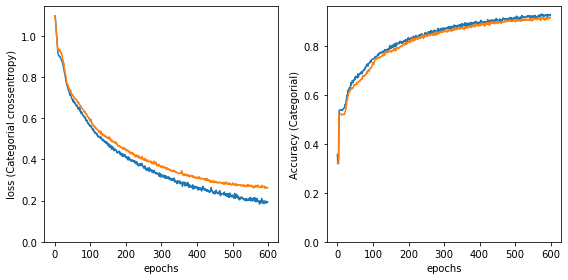

In [209]:
plotFitting(attention_optim)

66/66 [==============================] - 0s 2ms/step - loss: 0.2396 - categorical_accuracy: 0.9200
correct classified: 92.0 %
              precision    recall  f1-score   support

         1.0       0.91      0.97      0.94      1112
         2.0       0.96      0.92      0.94       307
         3.0       0.92      0.85      0.88       681

    accuracy                           0.92      2100
   macro avg       0.93      0.91      0.92      2100
weighted avg       0.92      0.92      0.92      2100



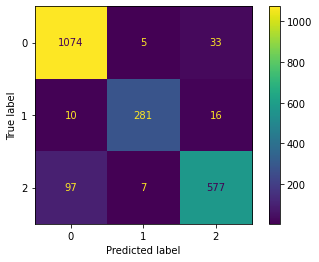

In [210]:
evaluatePerformance(attention_model)

In [246]:
attention_layer = [n for n in attention_model.layers if 'attention_' in n.name][0]
weight_model = kr.Model(inputs=attention_model.inputs,outputs=[attention_model.outputs,attention_layer.output])
classes,attention_weights = weight_model.predict(x_test[:1])

Text(33.0, 0.5, 'Feature')

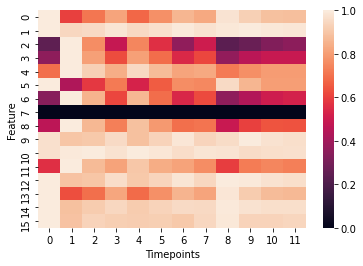

In [247]:
import seaborn as sns
sns.heatmap((attention_weights[0]/(np.max(attention_weights[0],axis=0)+1e-12)).T)
plt.xlabel('Timepoints')
plt.ylabel('Feature')

# Comparison of models

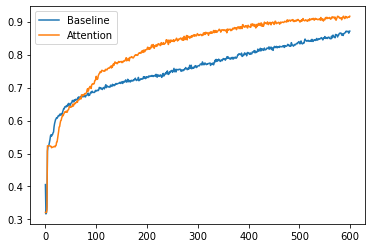

In [240]:
plt.plot(baseline_optim.history['val_categorical_accuracy'],label='Baseline')
plt.plot(attention_optim.history['val_categorical_accuracy'],label='Attention')
plt.legend()
plt.show()